In [4]:
import os
from pathlib import Path

os.environ['MMWHS_CACHE_PATH'] = str(Path('.', '.cache'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp

from tqdm import tqdm
import wandb
import nibabel as nib

from slice_inflate.datasets.mmwhs_dataset import MMWHSDataset, load_data, extract_2d_data
from slice_inflate.utils.common_utils import DotDict, get_script_dir
from slice_inflate.utils.torch_utils import reset_determinism, ensure_dense, save_model
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import ImageGrid
from slice_inflate.datasets.align_mmwhs import cut_slice
from slice_inflate.utils.log_utils import get_global_idx, log_label_metrics, log_oa_metrics
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

from mdl_seg_class.metrics import dice3d
import numpy as np

from IPython import display

THIS_SCRIPT_DIR = get_script_dir()

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure


In [35]:
files = Path("/share/data_supergrover1/weihsbach/shared_data/tmp/slice_inflate/data/output/worthy-resonance-122_best/").glob("*.pth")
USE_EYE_AFFINE = True

for pth_path in files:
    data = torch.load(pth_path)
    base_path = Path(pth_path.parent, f"{data['batch']['id'][0]}")
    if USE_EYE_AFFINE:
        sa_affine = np.eye(4)
    else:
        sa_affine = data['batch']['sa_affine'].squeeze(0)
    nib.save(nib.Nifti1Image(data['input'].argmax(1).squeeze(0).cpu().int().numpy(), sa_affine), str(base_path)+"_input.nii.gz")
    nib.save(nib.Nifti1Image(data['target'].argmax(1).squeeze(0).cpu().int().numpy(), sa_affine), str(base_path)+"_target.nii.gz")
    nib.save(nib.Nifti1Image(data['output'].argmax(1).squeeze(0).cpu().int().numpy(), sa_affine), str(base_path)+"_output.nii.gz")
    nib.save(nib.Nifti1Image(data['batch']['image'].squeeze(0).cpu().float().numpy(), sa_affine), str(base_path)+"_corresponding_input_image.nii.gz")
    # hla_affine = data['batch']['hla_affine'].squeeze(0)
    # D_slc, H_slc = data['batch']['hla_label_slc'].squeeze(0).shape
    # nib.save(nib.Nifti1Image(data['batch']['hla_label_slc'].squeeze(0).view(1, D_slc, H_slc).cpu().float().numpy(), hla_affine), str(base_path)+"_hla_label_slice.nii.gz")

# Create meshes

In [3]:
config_dict = DotDict({
    'num_folds': 5,
    'only_first_fold': True,                # If true do not contiue with training after the first fold
    # 'fold_override': 0,
    # 'checkpoint_epx': 0,
                   # If true use MIND features (https://pubmed.ncbi.nlm.nih.gov/22722056/)
    'epochs': 500,

    'batch_size': 4,
    'val_batch_size': 1,
    'modality': 'mr',
    'use_2d_normal_to': None,               # Can be None or 'D', 'H', 'W'. If not None 2D slices will be selected for training

    'dataset': 'mmwhs',                 # The dataset prepared with our preprocessing scripts
    'data_base_path': str(Path(THIS_SCRIPT_DIR, "data/MMWHS")),
    'reg_state': None, # Registered (noisy) labels used in training. See prepare_data() for valid reg_states
    'train_set_max_len': None,              # Length to cut of dataloader sample count
    'crop_around_3d_label_center': (128,128,128),
    'crop_3d_region': ((0,128), (0,128), (0,128)),        # dimension range in which 3D samples are cropped
    'crop_2d_slices_gt_num_threshold': 0,   # Drop 2D slices if less than threshold pixels are positive

    'lr': 1e-3,
    'use_scheduling': True,

    'save_every': 'best',
    'mdl_save_prefix': 'data/models',

    'debug': False,
    'wandb_mode': 'online',                         # e.g. online, disabled. Use weights and biases online logging
    'do_sweep': False,                                # Run multiple trainings with varying config values defined in sweep_config_dict below

    # For a snapshot file: dummy-a2p2z76CxhCtwLJApfe8xD_fold0_epx0
    'checkpoint_name': None,                          # Training snapshot name, e.g. dummy-a2p2z76CxhCtwLJApfe8xD
    'fold_override': None,                            # Training fold, e.g. 0
    'checkpoint_epx': None,                           # Training epx, e.g. 0

    'do_plot': False,                                 # Generate plots (debugging purpose)
    'save_dp_figures': False,                         # Plot data parameter value distribution
    'save_labels': True,                              # Store training labels alongside data parameter values inside the training snapshot

    'device': 'cuda'
})

In [5]:
def prepare_data(config):
    training_dataset = MMWHSDataset(
        config.data_base_path,
        state="train",
        load_func=load_data,
        extract_slice_func=extract_2d_data,
        modality=config.modality,
        do_align_global=True,
        do_resample=False, # Prior to cropping, resample image?
        crop_3d_region=None, # Crop or pad the images to these dimensions
        crop_around_3d_label_center=config.crop_around_3d_label_center,
        pre_interpolation_factor=1., # When getting the data, resize the data by this factor
        ensure_labeled_pairs=True, # Only use fully labelled images (segmentation label available)
        use_2d_normal_to=config.use_2d_normal_to, # Use 2D slices cut normal to D,H,>W< dimensions
        crop_around_2d_label_center=(128,128),

        augment_angle_std=5,

        device=config.device,
        debug=config.debug
    )

    return training_dataset

training_dataset = prepare_data(config_dict)

Loading MMWHS train images and labels... (['mr'])


15 images, 15 labels: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (15)
Data import finished.
Dataloader will yield 3D samples


In [ ]:
# fig = plt.figure(figsize=(4, 4))
# ax = fig.add_subplot(111, projection='3d')
# # Use marching cubes to obtain the surface mesh of these ellipsoids
# sp = 1.0
# verts, faces, normals, values = measure.marching_cubes(first_class.cpu().numpy(), spacing=(sp,sp,sp), step_size=4)

# mesh = Poly3DCollection(verts[faces])
# mesh.set_edgecolor('k')
# ax.add_collection3d(mesh)

# ax.set_xlim(0, 128)
# ax.set_ylim(0, 128)
# ax.set_zlim(0, 128)

# plt.tight_layout()
# plt.show()

In [6]:
sample = training_dataset[1]
label = torch.nn.functional.one_hot(sample['label'], len(training_dataset.label_tags))
print(sample['id'])
SPACING = (1,1,1)
STEP_SIZE = 2

heart_data = {}
for class_idx, tag in enumerate(training_dataset.label_tags):
    if class_idx == 0: continue

    sub_label = label[:,:,:,class_idx]
    verts, faces, normals, values = measure.marching_cubes(sub_label.cpu().numpy(), spacing=SPACING, step_size=STEP_SIZE)
    data = dict(
        verts=torch.as_tensor(verts.copy()),
        faces=torch.as_tensor(faces.copy()),
        normals=torch.as_tensor(normals.copy()), 
        values=torch.as_tensor(values.copy())
    )
    heart_data[tag] = data

heart_data['sa_affine'] = sample['sa_affine']
heart_data['hla_affine'] = sample['hla_affine']

torch.save(heart_data, 'mmwhs_sample2_clouds.pth')
nib.save(nib.Nifti1Image(sample['label'].int().numpy(), affine=sample['sa_affine'].numpy()), "mmwhs_sample2_sa_label.nii.gz")
nib.save(nib.Nifti1Image(sample['hla_label_slc'].int().numpy(), affine=sample['hla_affine'].numpy()), "mmwhs_sample2_hla_label_slc.nii.gz")

1007-mr


## View full heart

In [ ]:
heart_data = torch.load('mmwhs_sample2_clouds.pth')

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(0, 128)
ax.set_ylim(0, 128)
ax.set_zlim(0, 128)

for tag, tag_data in heart_data.items():
    if 'affine' in tag: continue
    verts = tag_data['verts']
    ax.scatter(verts[:,0], verts[:,1], verts[:,2], s=1)

def anim_func(frame):
    angle = frame
    ax.view_init(30, angle)

plt.rcParams['animation.ffmpeg_path'] = "/home/weihsbach/miniconda3/envs/binaries/bin/ffmpeg"

anim_created = FuncAnimation(fig, anim_func, frames=360, interval=25)
display.display(display.HTML(anim_created.to_html5_video()))


## View sliced heart

In [ ]:
def get_distance_from_plane(normal, support, point):
    normal = normal / normal.dot(normal).sqrt() # Get unit vector
    diff = point-support.to(dtype=normal.dtype)
    dist = normal.dot(diff).abs()
    return dist


In [ ]:
heart_data = torch.load('mmwhs_sample2_clouds.pth')

SA_NORMAL = torch.tensor([0.,0.,1.])
SUPPORT = torch.tensor([64.,64.,64.])

# sa_to_hla = heart_data['sa_affine'].inverse() @ heart_data['hla_affine']
# hla_normal = (sa_to_hla @ torch.tensor([0.,0.,1.,0.]).to(dtype=sa_to_hla.dtype))[:3].flip(0)
# hla_support = (sa_to_hla @ torch.tensor([64.,64.,64.,1.]).to(dtype=sa_to_hla.dtype))[:3].flip(0)
hla_to_sa = heart_data['sa_affine'].inverse() @ heart_data['hla_affine']
sa_to_hla = hla_to_sa.inverse()

hla_normal = (hla_to_sa @ torch.tensor([0.,0.,1.,0.]).to(dtype=sa_to_hla.dtype))[:3]
hla_support = (hla_to_sa @ torch.tensor([64.,64.,64.,1.]).to(dtype=sa_to_hla.dtype))[:3]
hla_support = hla_support
print(hla_normal)
print(hla_support)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(0, 128)
ax.set_ylim(0, 128)
ax.set_zlim(0, 128)
s=1

for tag, tag_data in heart_data.items():
    if 'affine' in tag: continue
    verts = tag_data['verts']
    selected_verts = []
    for normal, support in [(SA_NORMAL, SUPPORT), (hla_normal, hla_support)]:
        selected_verts.extend([v for v in verts if get_distance_from_plane(normal, support, v) < 1.])
    if len(selected_verts) > 0:
        selected_verts = torch.stack(selected_verts)
        ax.scatter(selected_verts[:,0], selected_verts[:,1], selected_verts[:,2], s=s, label=tag)
    else:
        ax.scatter([],[],[],s=s,label=tag)

def anim_func(frame):
    angle = frame * 2
    ax.view_init(0., angle)
    
plt.legend()
plt.rcParams['animation.ffmpeg_path'] = "/home/weihsbach/miniconda3/envs/binaries/bin/ffmpeg"

anim_created = FuncAnimation(fig, anim_func, frames=180, interval=50)
display.display(display.HTML(anim_created.to_html5_video()))

shaperformer

In [ ]:
shapeformer_data = np.load("/share/data_supergrover1/weihsbach/shared_data/tmp/ShapeFormer/out.npy")

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')

SPACING = (1,1,1)
STEP_SIZE = 2

verts = shapeformer_data
ax.scatter(verts[:,0], verts[:,1], verts[:,2], s=1)

import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

def anim_func(frame):
    angle = frame
    ax.view_init(30, angle)

plt.rcParams['animation.ffmpeg_path'] = "/home/weihsbach/miniconda3/envs/binaries/bin/ffmpeg"

anim_created = FuncAnimation(fig, anim_func, frames=360, interval=25)
display.display(display.HTML(anim_created.to_html5_video()))


# Compare against mean shape

In [156]:
os.environ['MMWHS_CACHE_PATH'] = str(Path('.', '.cache'))
PROJECT_NAME = "slice_inflate"

from pathlib import Path
from slice_inflate.utils.common_utils import DotDict, get_script_dir, in_notebook
from slice_inflate.datasets.mmwhs_dataset import MMWHSDataset, load_data, extract_2d_data
import torch
from matplotlib import pyplot as plt
import SimpleITK as sitk # https://simpleitk.org/
import numpy as np

THIS_SCRIPT_DIR = get_script_dir()

config_dict = DotDict(dict(
    state='train',
    dataset='mmwhs',
    modality='all',
    use_2d_normal_to=None,
    data_base_path=str(Path(THIS_SCRIPT_DIR, "data/MMWHS")),
    crop_3d_region=None, #((0,128), (0,128), (0,128)), # dimension range in which 3D samples are cropped
    crop_2d_slices_gt_num_threshold=0,   # Drop 2D slices if less than threshold pixels are positive
    crop_around_3d_label_center=(128,128,128), #(128,128,128),
    crop_around_2d_label_center=(128,128),
    align_fov_mm=(300.,300.,300.),
    align_fov_vox=(196,196,196),
    max_load_3d_num=None,
    device='cuda',
    debug=False,
))

def prepare_data(config):
    training_dataset = MMWHSDataset(
        config.data_base_path,
        state=config.state,
        load_func=load_data,
        extract_slice_func=extract_2d_data,
        modality=config.modality,
        do_align_global=True,
        do_resample=False, # Prior to cropping, resample image?
        crop_3d_region=None, # Crop or pad the images to these dimensions
        align_fov_mm=config.align_fov_mm,
        align_fov_vox=config.align_fov_vox,
        crop_around_3d_label_center=config.crop_around_3d_label_center,
        pre_interpolation_factor=1., # When getting the data, resize the data by this factor
        ensure_labeled_pairs=True, # Only use fully labelled images (segmentation label available)
        use_2d_normal_to=config.use_2d_normal_to, # Use 2D slices cut normal to D,H,>W< dimensions
        crop_around_2d_label_center=config.crop_around_2d_label_center,
        max_load_3d_num=config.max_load_3d_num,

        augment_angle_std=5,

        device=config.device,
        debug=config.debug
    )

    return training_dataset
training_dataset, test_dataset = None, None

if training_dataset is None:
    train_config = DotDict(config_dict.copy())
    training_dataset = prepare_data(train_config)

if test_dataset is None:
    test_config = DotDict(config_dict.copy())
    test_config['state'] = 'test'
    test_dataset = prepare_data(test_config)

Loading MMWHS train images and labels... (['mr', 'ct'])


30 images, 30 labels: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (30)
Data import finished.
Dataloader will yield 3D samples
Loading MMWHS test images and labels... (['mr', 'ct'])


10 images, 10 labels: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (10)
Data import finished.
Dataloader will yield 3D samples


In [158]:
print("training ids:", [smp['id'] for smp in training_dataset])
print("testing ids:", [smp['id'] for smp in test_dataset])

training ids: ['1004-ct', '1004-mr', '1007-ct', '1007-mr', '1008-ct', '1008-mr', '1009-ct', '1009-mr', '1010-ct', '1010-mr', '1011-ct', '1011-mr', '1012-ct', '1012-mr', '1013-ct', '1013-mr', '1014-ct', '1014-mr', '1015-ct', '1015-mr', '1016-ct', '1016-mr', '1017-ct', '1017-mr', '1018-ct', '1018-mr', '1019-ct', '1019-mr', '1020-ct', '1020-mr']
testing ids: ['1001-ct', '1001-mr', '1002-ct', '1002-mr', '1003-ct', '1003-mr', '1005-ct', '1005-mr', '1006-ct', '1006-mr']


In [17]:
training_dataset.eval()
train_samples = []
for sample in training_dataset:
    train_samples.append(sample['label'])

train_samples = torch.stack(train_samples)

torch.Size([30, 128, 128, 128])


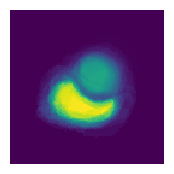

In [146]:
print(train_samples.shape)
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(train_samples.sum(0)[:,:,64], interpolation='none')
plt.show()

In [29]:
uniques, counts = train_samples.unique(return_counts=True, dim=0)
if uniques.numel() > 1:
    pass
sorted_idxs = counts.argsort()
resulting_label = uniques[sorted_idxs][0]
# print(resulting_label)

In [49]:
def bincount(tens, length, dim=-1):
  """Count the number of ocurrences of each value along an axis."""
  mask = (tens[...].unsqueeze(-1) == torch.arange(length)) # Last dimension will be broadcasted
  return mask.count_nonzero(dim=dim-1 if dim < 0 else dim)

bncount_along_samples = bincount(train_samples, train_samples.max()+1, dim=0)
bncount_along_samples.shape

torch.Size([128, 128, 128, 6])

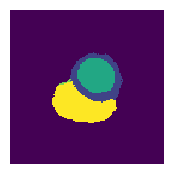

In [144]:
majority_voted = bncount_along_samples.argmax(-1)
majority_voted.shape
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(majority_voted[:,:,64], interpolation='none', vmax=5)
plt.show()

In [51]:
from mdl_seg_class.metrics import dice3d
test_dataset.eval()

test_samples = []
for sample in test_dataset:
    test_samples.append(sample['label'])

test_samples = torch.stack(test_samples)


torch.Size([10, 128, 128, 128])


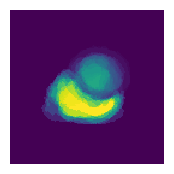

In [145]:
print(test_samples.shape)
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(test_samples.sum(0)[:,:,64], interpolation='none')
plt.show()

In [55]:
dice3d(
    torch.nn.functional.one_hot(majority_voted).repeat(10,1,1,1,1),
    torch.nn.functional.one_hot(test_samples),
    one_hot_torch_style=True
)[:,1:].mean()

tensor(0.6297)

In [115]:
def calc_multilabel_staple_consensus(lbl_list):
    staple_filter = sitk.MultiLabelSTAPLEImageFilter()
    # sitk.ProcessObject.SetGlobalDefaultDebugOff()
    staple_filter.SetMaximumNumberOfIterations(200)
    staple_filter.SetLabelForUndecidedPixels(0)
    sitk_moving_data = [sitk.GetImageFromArray(lbl.to_dense().numpy().astype(np.uint64)) for lbl in lbl_list]
    
    staple_out = staple_filter.Execute(sitk_moving_data)
    consensus = torch.tensor(sitk.GetArrayFromImage(staple_out).astype(np.int64))

    return consensus

In [116]:
stapled = calc_multilabel_staple_consensus([smp for smp in train_samples])

tensor([0, 1, 2, 3, 4, 5])


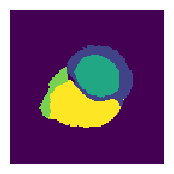

In [147]:
print(stapled.unique())
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(stapled[:,:,64], interpolation='none', vmax=5)
plt.show()

In [127]:
print(f"testset vs. stapled: {dice3d(torch.nn.functional.one_hot(stapled).repeat(10,1,1,1,1),torch.nn.functional.one_hot(test_samples), one_hot_torch_style=True)[:,1:].mean().item()*100:.3f}%")
print(f"testset vs. majority_voted: {dice3d(torch.nn.functional.one_hot(majority_voted).repeat(10,1,1,1,1),torch.nn.functional.one_hot(test_samples), one_hot_torch_style=True)[:,1:].mean().item()*100:.3f}%")

testset vs. stapled: 54.372%
testset vs. majority_voted: 62.972%


# Analyse latent space

In [ ]:
from main_slice_inflate import run

# OTHER